<a href="https://colab.research.google.com/github/lwachowiak/Emotion-Recognition-with-ViT/blob/main/Emotion_Recognition_using_the_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Emotion Recognition with the Vision Transformer (ViT)

Find on Github: https://github.com/lwachowiak/Emotion-Recognition-with-ViT

This notebook presents an adaptation of the finetuning approach for [ViT](https://arxiv.org/pdf/2010.11929.pdf) using HuggingFace of [this notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_🤗_Trainer.ipynb). Here, I finetune ViT for emotion classification.


Google Brain's ViT is a transformer encoder (like BERT)  pretrained on vision data instead of text. 

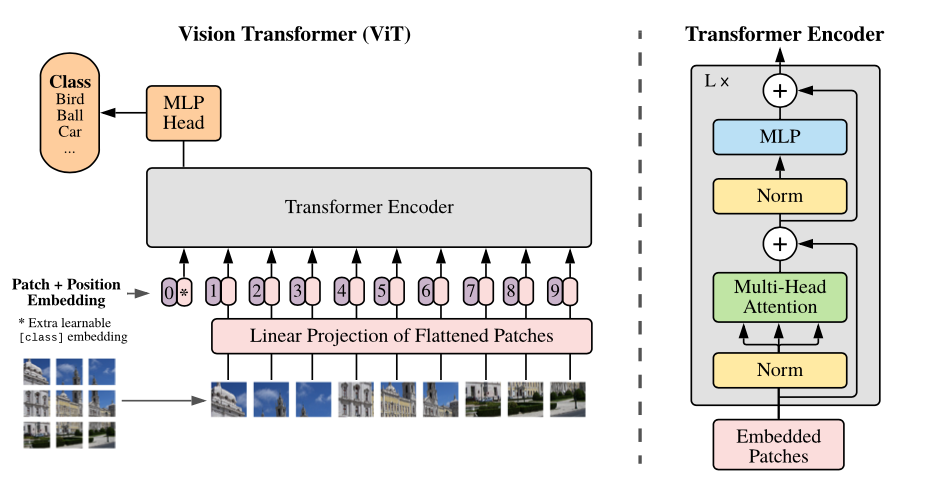



If you want to execute this notebook on **Google Colab** you might have to reduce the training set size due to RAM issues.

In [1]:
# !pip install -q git+https://github.com/huggingface/transformers datasets

In [ ]:
from datasets import *
from transformers import ViTFeatureExtractor
from transformers import ViTModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
print("GPU available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

c:\Users\15432\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU available: True
Number of GPUs: 1


## Preprocessing



I finetune ViT on the Facial Expression Recognition 2013 (FER-2013) dataset, which consists of 35.887 48x48 pixel grayscale images representing 7 different emotions.
It is preprocessed using `ViTFeatureExtractor`, which resizes every image to the resolution that the model expects, i.e. 224x224, and normalizes the channels.

Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

Dataset Paper: https://arxiv.org/pdf/1307.0414.pdf



In [3]:
string_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

In [4]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

c:\Users\15432\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Load original data into a DataFrame

In [5]:
fer_df = pd.read_csv("fer2013.csv")  # available on kaggle

In [6]:
fer_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


First preprocessing step

In [7]:
def prepare_fer_data(data):
    """ Prepare fer data for vision transformer 
        input: fer df loaded from csv
        output: df that can be load into a huggingface dataset """

    # outputs
    image_list = []
    image_labels = list(map(int, data['emotion']))
    
    # go over all images
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        # adapt grayscale to rgb format (change single values to triplets of the same value)
        image = image[..., np.newaxis]
        image = np.repeat(image, 3, axis=2)
        # convert to list format used by the later functions
        image = image.astype(int).tolist()
        # save to output
        image_list.append(image)

    output_df = pd.DataFrame(list(zip(image_list, image_labels)),
               columns =['img', 'label'])
        
    return output_df

In [8]:
fer_train_df = prepare_fer_data(fer_df[fer_df['Usage']=='Training'])
fer_test_df = prepare_fer_data(fer_df[fer_df['Usage']=='PrivateTest'])
fer_val_df = prepare_fer_data(fer_df[fer_df['Usage']=='PublicTest'])

In [9]:
fer_train_df.head()

,img,label
0,"[[[70, 70, 70], [80, 80, 80], [82, 82, 82], [7...",0
1,"[[[151, 151, 151], [150, 150, 150], [147, 147,...",0
2,"[[[231, 231, 231], [212, 212, 212], [156, 156,...",2
3,"[[[24, 24, 24], [32, 32, 32], [36, 36, 36], [3...",4
4,"[[[4, 4, 4], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6


In [ ]:
print(len(fer_train_df))
print(len(fer_test_df))
print(len(fer_val_df))

28709
3589
3589


In [11]:
train_ds = Dataset.from_pandas(fer_train_df)
#undersample train due to memory issues on google colab
splits = train_ds.train_test_split(test_size=0.15)
train_ds = splits["train"]

val_ds = Dataset.from_pandas(fer_val_df)
test_ds = Dataset.from_pandas(fer_test_df)

train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 24402
})

In [12]:
# image size 
np.array(train_ds[0]["img"]).shape

(48, 48, 3)

Second preprocessing step using the ViT feature extractor

In [13]:
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [ ]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_ds = train_ds.map(
    preprocess_images,
    batched=True,
    batch_size=16,
    features=features,
)
preprocessed_val_ds = val_ds.map(
    preprocess_images,
    batched=True,
    batch_size=16,
    features=features,
)
preprocessed_test_ds = test_ds.map(
    preprocess_images,
    batched=True,
    batch_size=16,
    features=features,
)
# with open('preprocessed_train_ds.pickle', 'wb') as handle:
#     pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
# preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
# with open('preprocessed_val_ds.pickle', 'wb') as handle:
#    pickle.dump(preprocessed_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
# preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)
# with open('preprocessed_test_ds.pickle', 'wb') as handle:
#    pickle.dump(preprocessed_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

preprocessed_train_ds

Map:  86%|████████▌ | 3072/3589 [00:27<00:03, 147.74 examples/s]

In [ ]:
# final image size
print(len(preprocessed_train_ds[0]["pixel_values"]))       
print(len(preprocessed_train_ds[0]["pixel_values"][0]))     
print(len(preprocessed_train_ds[0]["pixel_values"][0][0]))  

3
224
224


## Looking at the Data 
Let's quickly look at some samples of processed data as well as the label distribution.

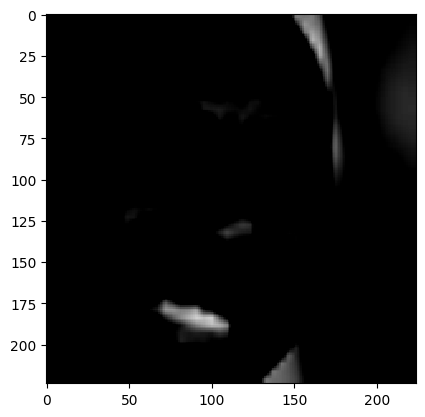

Happiness


In [ ]:
# show a single image from the dataset
data_for_image = np.array(preprocessed_train_ds[0]["pixel_values"])
data_for_image[data_for_image < 0] = 0 

plt.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
plt.show()

print(string_labels[preprocessed_train_ds[0]["label"]])

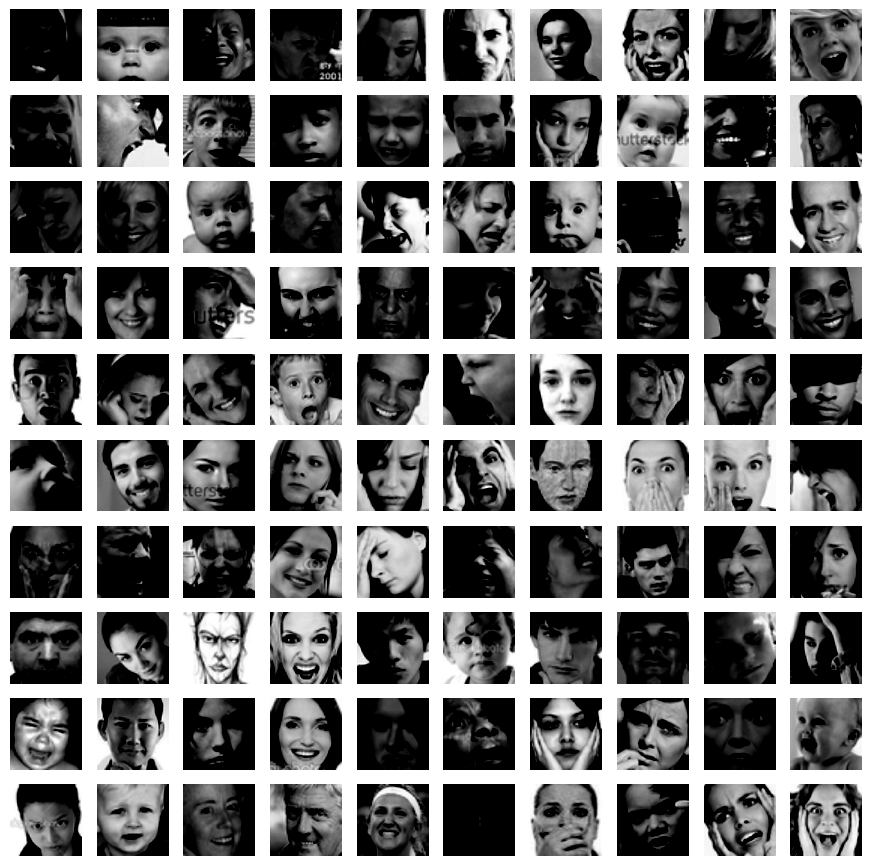

In [ ]:
# show 100 images from the dataset
fig, axes = plt.subplots(10,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(preprocessed_train_ds[i]["pixel_values"])
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
  ax.set_axis_off()


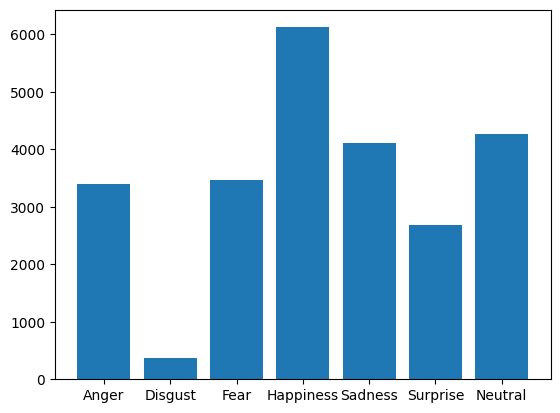

In [ ]:
# distribution of labels in the training set
keys, counts = np.unique(preprocessed_train_ds["label"], return_counts=True)
plt.bar(string_labels, counts)
plt.show()

## Defining the model

The model architecture is defined in PyTorch, with dropout and a linear layer added on top of the ViT model's output of the special CLS token representing the input picture. 


In [ ]:
class ViTForImageClassification(nn.Module):
    #define architecture
    def __init__(self, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

Training uses the standard HuggingFace [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) interface. 

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    evaluation_strategy = "epoch",
    save_strategy = "epoch" ,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    fp16 = True,
    no_cuda=False,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
)

c:\Users\15432\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1570: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification().to(device)

In [ ]:
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)

trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_val_ds,
    compute_metrics = compute_metrics,
)

Map: 100%|██████████| 3589/3589 [01:00<00:00, 59.23 examples/s] 


## Fine-tuning ViT


Fine-tuning the model by calling the `train()` method

In [ ]:
trainer.train()

  0%|          | 0/18306 [00:00<?, ?it/s]c:\Users\15432\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
  3%|▎         | 501/18306 [01:56<1:07:52,  4.37it/s]

{'loss': 1.4334, 'grad_norm': 4.6620306968688965, 'learning_rate': 1.945373101715285e-05, 'epoch': 0.16}


  5%|▌         | 1000/18306 [03:51<1:07:09,  4.30it/s]

{'loss': 1.142, 'grad_norm': 4.979066848754883, 'learning_rate': 1.8907462034305696e-05, 'epoch': 0.33}


  8%|▊         | 1500/18306 [05:44<1:03:39,  4.40it/s]

{'loss': 1.0666, 'grad_norm': 10.471054077148438, 'learning_rate': 1.836119305145854e-05, 'epoch': 0.49}


 11%|█         | 2001/18306 [07:38<1:03:12,  4.30it/s]

{'loss': 1.0119, 'grad_norm': 3.9422004222869873, 'learning_rate': 1.781601660657708e-05, 'epoch': 0.66}


 14%|█▎        | 2500/18306 [09:31<1:00:08,  4.38it/s]

{'loss': 0.993, 'grad_norm': 8.844303131103516, 'learning_rate': 1.7269747623729926e-05, 'epoch': 0.82}


 16%|█▋        | 3000/18306 [11:25<58:13,  4.38it/s]  

{'loss': 0.944, 'grad_norm': 5.6893157958984375, 'learning_rate': 1.672347864088277e-05, 'epoch': 0.98}


                                                    
 17%|█▋        | 3051/18306 [13:04<44:00,  5.78it/s]

{'eval_loss': 1.0051661729812622, 'eval_accuracy': 0.6246865422123155, 'eval_runtime': 87.9549, 'eval_samples_per_second': 40.805, 'eval_steps_per_second': 5.105, 'epoch': 1.0}


 19%|█▉        | 3501/18306 [14:45<54:10,  4.55it/s]    

{'loss': 0.8346, 'grad_norm': 6.882617950439453, 'learning_rate': 1.6177209658035617e-05, 'epoch': 1.15}


 22%|██▏       | 4001/18306 [16:35<49:01,  4.86it/s]  

{'loss': 0.7592, 'grad_norm': 3.9892866611480713, 'learning_rate': 1.5630940675188464e-05, 'epoch': 1.31}


 25%|██▍       | 4500/18306 [18:16<48:18,  4.76it/s]

{'loss': 0.8141, 'grad_norm': 14.057944297790527, 'learning_rate': 1.5084671692341311e-05, 'epoch': 1.47}


 27%|██▋       | 5001/18306 [19:59<45:25,  4.88it/s]

{'loss': 0.7882, 'grad_norm': 6.169538497924805, 'learning_rate': 1.4539495247459849e-05, 'epoch': 1.64}


 30%|███       | 5501/18306 [21:42<43:14,  4.94it/s]

{'loss': 0.7935, 'grad_norm': 5.1308488845825195, 'learning_rate': 1.3993226264612696e-05, 'epoch': 1.8}


 33%|███▎      | 6001/18306 [23:24<42:25,  4.83it/s]

{'loss': 0.741, 'grad_norm': 7.382425785064697, 'learning_rate': 1.3448049819731237e-05, 'epoch': 1.97}


                                                    
 33%|███▎      | 6102/18306 [24:57<38:18,  5.31it/s]

{'eval_loss': 0.8793388605117798, 'eval_accuracy': 0.6876567288938423, 'eval_runtime': 72.0472, 'eval_samples_per_second': 49.815, 'eval_steps_per_second': 6.232, 'epoch': 2.0}


 36%|███▌      | 6501/18306 [26:19<40:20,  4.88it/s]   

{'loss': 0.6092, 'grad_norm': 3.4643051624298096, 'learning_rate': 1.2901780836884084e-05, 'epoch': 2.13}


 38%|███▊      | 7001/18306 [28:00<37:43,  5.00it/s]

{'loss': 0.5671, 'grad_norm': 46.7607536315918, 'learning_rate': 1.2355511854036928e-05, 'epoch': 2.29}


 41%|████      | 7501/18306 [29:41<36:38,  4.91it/s]

{'loss': 0.5768, 'grad_norm': 1.7269742488861084, 'learning_rate': 1.1809242871189775e-05, 'epoch': 2.46}


 44%|████▎     | 8001/18306 [31:21<34:54,  4.92it/s]

{'loss': 0.5857, 'grad_norm': 9.128904342651367, 'learning_rate': 1.1264066426308316e-05, 'epoch': 2.62}


 46%|████▋     | 8501/18306 [33:03<33:43,  4.85it/s]

{'loss': 0.5369, 'grad_norm': 5.805801868438721, 'learning_rate': 1.0717797443461161e-05, 'epoch': 2.79}


 49%|████▉     | 9001/18306 [34:46<32:39,  4.75it/s]

{'loss': 0.5678, 'grad_norm': 10.840912818908691, 'learning_rate': 1.0171528460614007e-05, 'epoch': 2.95}


                                                    
 50%|█████     | 9153/18306 [36:27<27:33,  5.54it/s]

{'eval_loss': 0.938868522644043, 'eval_accuracy': 0.6887712454722764, 'eval_runtime': 69.9404, 'eval_samples_per_second': 51.315, 'eval_steps_per_second': 6.42, 'epoch': 3.0}


 52%|█████▏    | 9501/18306 [37:42<30:03,  4.88it/s]   

{'loss': 0.434, 'grad_norm': 17.432214736938477, 'learning_rate': 9.625259477766852e-06, 'epoch': 3.11}


 55%|█████▍    | 10001/18306 [39:22<28:24,  4.87it/s]

{'loss': 0.3653, 'grad_norm': 6.320925712585449, 'learning_rate': 9.080083032885393e-06, 'epoch': 3.28}


 57%|█████▋    | 10501/18306 [41:03<26:06,  4.98it/s]

{'loss': 0.3762, 'grad_norm': 14.506689071655273, 'learning_rate': 8.533814050038239e-06, 'epoch': 3.44}


 60%|██████    | 11001/18306 [42:45<24:18,  5.01it/s]

{'loss': 0.3837, 'grad_norm': 0.9530344009399414, 'learning_rate': 7.987545067191086e-06, 'epoch': 3.61}


 63%|██████▎   | 11501/18306 [45:05<23:33,  4.81it/s]   

{'loss': 0.3631, 'grad_norm': 28.763626098632812, 'learning_rate': 7.441276084343931e-06, 'epoch': 3.77}


 66%|██████▌   | 12000/18306 [46:48<21:43,  4.84it/s]

{'loss': 0.3478, 'grad_norm': 9.548049926757812, 'learning_rate': 6.8950071014967775e-06, 'epoch': 3.93}


                                                     
 67%|██████▋   | 12204/18306 [48:44<18:19,  5.55it/s]

{'eval_loss': 1.0665647983551025, 'eval_accuracy': 0.6918361660629702, 'eval_runtime': 73.3405, 'eval_samples_per_second': 48.936, 'eval_steps_per_second': 6.122, 'epoch': 4.0}


 68%|██████▊   | 12501/18306 [49:49<20:25,  4.74it/s]   

{'loss': 0.2766, 'grad_norm': 2.448219060897827, 'learning_rate': 6.348738118649623e-06, 'epoch': 4.1}


 71%|███████   | 13000/18306 [51:31<18:10,  4.86it/s]

{'loss': 0.2371, 'grad_norm': 3.9171571731567383, 'learning_rate': 5.80246913580247e-06, 'epoch': 4.26}


 74%|███████▍  | 13501/18306 [53:13<16:42,  4.79it/s]

{'loss': 0.2194, 'grad_norm': 4.566567897796631, 'learning_rate': 5.256200152955315e-06, 'epoch': 4.42}


 76%|███████▋  | 14001/18306 [54:56<14:26,  4.97it/s]

{'loss': 0.2229, 'grad_norm': 0.2016163319349289, 'learning_rate': 4.711023708073856e-06, 'epoch': 4.59}


 79%|███████▉  | 14500/18306 [56:38<15:06,  4.20it/s]

{'loss': 0.211, 'grad_norm': 6.2002387046813965, 'learning_rate': 4.164754725226702e-06, 'epoch': 4.75}


 82%|████████▏ | 15001/18306 [58:21<11:46,  4.68it/s]

{'loss': 0.2381, 'grad_norm': 5.954811096191406, 'learning_rate': 3.6184857423795477e-06, 'epoch': 4.92}


                                                     
 83%|████████▎ | 15255/18306 [1:00:24<09:06,  5.58it/s]

{'eval_loss': 1.3037481307983398, 'eval_accuracy': 0.694901086653664, 'eval_runtime': 70.2405, 'eval_samples_per_second': 51.096, 'eval_steps_per_second': 6.392, 'epoch': 5.0}


 85%|████████▍ | 15501/18306 [1:01:15<09:22,  4.98it/s]   

{'loss': 0.1892, 'grad_norm': 1.6686803102493286, 'learning_rate': 3.0722167595323936e-06, 'epoch': 5.08}


 87%|████████▋ | 16001/18306 [1:02:56<07:43,  4.97it/s]

{'loss': 0.1367, 'grad_norm': 1.4545639753341675, 'learning_rate': 2.5259477766852402e-06, 'epoch': 5.24}


 90%|█████████ | 16501/18306 [1:04:37<06:30,  4.62it/s]

{'loss': 0.1256, 'grad_norm': 0.06617466360330582, 'learning_rate': 1.979678793838086e-06, 'epoch': 5.41}


 93%|█████████▎| 17001/18306 [1:06:23<04:26,  4.90it/s]

{'loss': 0.1347, 'grad_norm': 3.0687708854675293, 'learning_rate': 1.433409810990932e-06, 'epoch': 5.57}


 96%|█████████▌| 17501/18306 [1:08:05<02:44,  4.91it/s]

{'loss': 0.1372, 'grad_norm': 0.12200206518173218, 'learning_rate': 8.87140828143778e-07, 'epoch': 5.74}


 98%|█████████▊| 18001/18306 [1:09:49<01:02,  4.85it/s]

{'loss': 0.1453, 'grad_norm': 0.08148876577615738, 'learning_rate': 3.4196438326231837e-07, 'epoch': 5.9}


                                                       
100%|██████████| 18306/18306 [1:12:40<00:00,  4.67it/s]

{'eval_loss': 1.384279489517212, 'eval_accuracy': 0.6918361660629702, 'eval_runtime': 102.6055, 'eval_samples_per_second': 34.979, 'eval_steps_per_second': 4.376, 'epoch': 6.0}


100%|██████████| 18306/18306 [1:12:42<00:00,  4.20it/s]

{'train_runtime': 4362.28, 'train_samples_per_second': 33.563, 'train_steps_per_second': 4.196, 'train_loss': 0.5297186070161609, 'epoch': 6.0}


TrainOutput(global_step=18306, training_loss=0.5297186070161609, metrics={'train_runtime': 4362.28, 'train_samples_per_second': 33.563, 'train_steps_per_second': 4.196, 'total_flos': 0.0, 'train_loss': 0.5297186070161609, 'epoch': 6.0})

## Evaluation on Test Set

The test score after fine-tuning

In [ ]:
outputs = trainer.predict(preprocessed_test_ds)
print(outputs.metrics)
torch.save(model.state_dict(),"Google-ViT-base-patch16-224-in21k_2.pth")

100%|██████████| 449/449 [02:55<00:00,  2.56it/s]


{'test_loss': 1.2069058418273926, 'test_accuracy': 0.71078294789635, 'test_runtime': 175.8865, 'test_samples_per_second': 20.405, 'test_steps_per_second': 2.553}


The results on the test set as confusion matrix

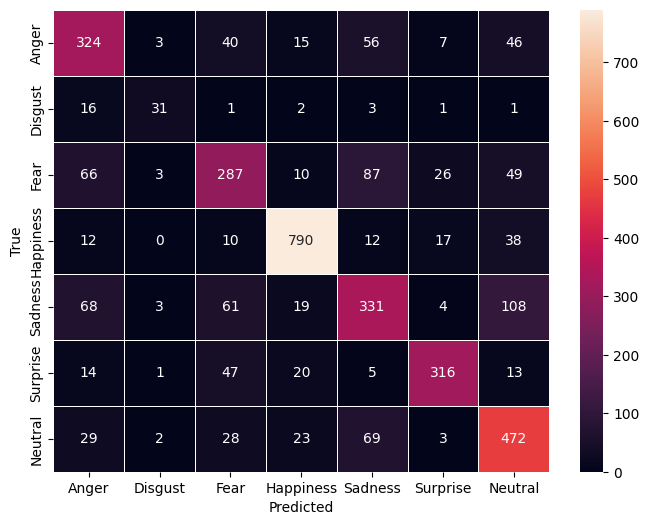

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
fig, ax = plt.subplots(figsize=(8,6))  
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()